# Knapsacking the area coverage problem

## Introductory remarks 

This notebook uses `cvxpy`, available from [cvxpy.org]( https://www.cvxpy.org/install/index.html).

I have also installed `cvxopt` to make sure all the solvers that come packaged with cvxpy will work on my machine.

On my computer all this is available in the conda environment: `csp`

Some of this notebook relies on the GLPK_MI solver. This is a special solver designed for IP problems. 


To install GLPK (in /usr/local/):

- Download the latest version of GLPK from the [gnu](http://www.gnu.org/software/glpk/#downloading) website.
- `cd ~/Downloads`
- `tar -xzf glpk-4.43.tar.gz`
- `./configure -prefix=/usr/local`
- `make`
- `sudo make install`

At this point, you should have GLPK installed. 
To verify run: 
- `which glpsol`  
output: `/usr/local/bin/glpsol`


Introduction using GLPK [here](http://www.ibm.com/developerworks/linux/library/l-glpk1)


Good introduction to cvxpy is [integer-programming-in-python](https://towardsdatascience.com/integer-programming-in-python-1cbdfa240df2)


 Before you solve your own problem, consult this table to see which prepackaged cvpxy solver is best suited to your problem.

# Introduction

The achieved maturity of autonomous underwater vehicles (AUVs) makes the deployment of multi-vehicle networks practical and cost-effective.
Most scientific and military applications nowdays require the usage of AUVs.
From an end user perspective the ability to scale from one asset to multiple vehicles able to coordinate their activities means maximising the benefits.
Network of AUVs have a wide range of commercial and military applications ranging from surveillance [[1](https://openlibrary.cmre.nato.int/bitstream/handle/20.500.12489/796/CMRE-PR-2019-056.pdf?sequence=1)] to mine-counter measurement operations or oceanographic systems [[2](https://ieeexplore.ieee.org/document/8729779)].

To maximise their operational effectiveness, one critical decision variable that has a direct impact on both the cost and performance, the lies in how to properly place the different sensors in the target environment.

The number of sensors, the dedicated communication networks, can contribute a significant portion of the overall cost. 
The placement of the vehicles determines the overall mission time and the associated coverage area.

In fact, one critical weakness of existing systems lies in the ability to plan multi-days, multi-vehicle missions over large areas. 
The ability to quickly allocate each vehicle to one specific area, to monitor the mission performance, and to understand the quality of the data gathered would represent a key capability to speed up the uptake of the technology even more.

In this regard, this work addresses the area coverage problem and aims at providing a solution to efficiently schedule AUV operations over multi-days and large areas.

# Related work 

# An approximate solution to the BIP area coverage problem

We consider the problem of surveying an area $\mathcal{A}$, with a fixed maximum number of robots $N$.

Each robot $i$ can only work for a specific amount of hours $T_i$, after which it has to go back and recharge its batteries.
Each robot is also equipped with a specific sensor $S_i$ that determines its maximum travelling speed $v_{max, i}$ and surveying trajectories. 
In this way, given a robot with a specific sensor configuration it is possible to calculate the maximum area coverage $A_i$ that the robot can cover in $T_i$ hours.

For example, in the case of a robot using a side scan sonar with a swath range $r$ that can travel at the maximum speed $v$, and work for $T$ hours, the maximum area coverage rate is: $A=rTv$.



Once each robot/sensor $i$ is associated to its maximum coverage area $A_i$, the area coverage problem can be casted as a maximal covering location problem [[3]](maximumal-covering-location-problem) with the objective of maximise coverage within a desired service distance $S$ by locating a fixed number of facilities (the robots).
The problem can also be generalised to include area that are to be prioritised. In this case, the priority of each area would correspond to the population covered in the classical formulation.

Solving this problem allows to obtain a trade-off curve showing the maximum possible coverage obtainable for given maximum area coverage per each robot and for various number of robots.

The maximal covering location problem that finds the maximum population (or area) that can be served within a desired time (or distance), given a limited number of facilities, can be stated as:

Maximise $z = \sum_{i\in I}{a_iy_i}$,

such that:
- $\sum_{j \in N_i}{x_j \ge y_i}$, $\forall i \in I$   (1)
- $\sum_{j \in J}{x_j} = P$                    (2)
- $x_j =\{0,1\}$, $\forall j \in J$            (3)
- $y_i =\{0,1\}$, $\forall i \in I$            (4)

 
where  
$I$ is the set of demand nodes;  
$J$ is the set of robots (or facility sites);  
$x_j$ is equal 1, if robot is allocated to site $j$, 0 otherwise;  
$N_i = \{j \in J | d_{ij} \le S \}$, with:    
$d_{ij}$ shortest distance from node $i$ to node $j$ and $S$ is the distance beyond which a demand point is considered uncovered (a different $S$ can be chosen for each demand point if desired). So $N_i$ is the set of facilities site that can cover the demand point $i$.   
Finally, $a_i$ is the population served at demand node $i$ (or the priority of the demand node $i$ and $p$ is the number of facilities to be located.

Note that:

Constraints of type (1) allow $y_i$ to equal 1 only when one or more facilities are established at sites in the set $N_i$ (that is, one or more facilities are located within $S$ distance units of demand point $i$). 

The number of facilities allocated is restricted to equal $p$ in constraint (2).

The solution to this problem specifies not only the largest amount of population that can be covered but the $p$ facilities that achieve this maximal coverage.

The maximal covering location problem has been solved optimally using linear programming and heuristically using several methods.


One simple way to solve it is using the Greedy Adding (GA) algorithm. In this case, the algorithm starts with an empty solution set and then adds one at a time the best facility sites. The process continues unitl either $p$ facilities have been selected or all the area (or population) is covered.

When $p > 1$ optimality is not guaranteed. It is important to note that the GA algorithm never removes facility sites from the solution set. Therefore, it is possible that a facility site added to the solution set in the early iterations of the algorithm may not be justified later in the algorithm due to subsequent facility site assignments.

The problem can be solved optimally using linear programming restricting $x_j$ and $y_j$ to be non negative instead of zero or one. In this case, the optimal solution is obtained when all $x$ and $y$ are in fact zero or one (all integer answer), whereas if a fractional answer is obtained, the optimal solution is not feasible.

## The Knapsack Problem 

We solve the problem in two steps.
First we solve a knapsack problem to select the robots/sensors, second we apply the greedy heuristic algorithm to find the final robot/area allocation.

Let us remind ourselves what the knapsack is:  
Given weights and values of $n$ items, we would like to put these items in a knapsack of capacity $W$ to get the maximum total value in the knapsack. 

The key to understand this problem is that when an item $i$ weights less than the knapsack's capacity we would like to include it if it increases the maximum value obtainable..
The maximum obtainable value by including item $i$ is thus equal to the value of item $i$ itself plus the maximum value that can be obtained with the remaining capacity of the knapsack. 
Note that this second part is a knapsack subproblem itself where the maximum capacity is that the remains after having added the item $i$.

In what follows we use cvxpy to solve it.

In [1]:
import cvxpy as cvx
import numpy as np

In [2]:
print(cvx.__version__)

1.0.25


In [8]:
cvx.installed_solvers()

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']

In [9]:
# The data for the Knapsack problem
# P is total weight capacity of sack
# weights and utilities are also specified
P = 165
weights = np.array([23, 31, 29, 44, 53, 38, 63, 85, 89, 82])
utilities = np.array([92, 57, 49, 68, 60, 43, 67, 84, 87, 72])

# The variable we are solving for
selection = cvx.Variable(len(weights), boolean=True)

# The sum of the weights should be less than or equal to P
weight_constraint = weights * selection <= P

# Our total utility is the sum of the item utilities
total_utility = utilities * selection

In [11]:
# We tell cvxpy that we want to maximize total utility 
# subject to weight_constraint. All constraints in 
# cvxpy must be passed as a list
knapsack_problem = cvx.Problem(cvx.Maximize(total_utility), [weight_constraint])


In [12]:
# Solving the problem
knapsack_problem.solve(solver=cvx.GLPK_MI)

309.0

In [13]:
print(selection.value)

[1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]


# Area assignment

In [1]:
%load_ext autoreload
%autoreload 2

import cvxpy as cvx
import numpy as np
import utils.utils as u
import math as m
from matplotlib import pylab as plt

## Drawing and preps 

In [6]:
xmin, xmax, dx = 0, 0.5, .1
ymin, ymax, dy = 0, 1, .1

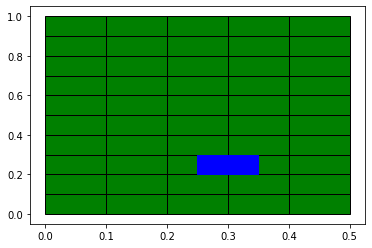

In [7]:
u.draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')
u.draw_cell(0.25, 0.2, 0.1, 0.1, edgecolor='blue', facecolor='blue')

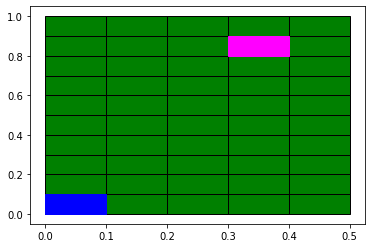

In [13]:
rxc_matrix = np.zeros((2, 100))
rxc_matrix[0,0] = 1
rxc_matrix[1,43] = 1


r_colors = ['blue', 'magenta', 'cyan']
u.draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')
u.draw_allocation(rxc_matrix, xmin, xmax, dx, ymin, ymax, dy, n_cells=100, n_robots=2, r_colors=r_colors)           

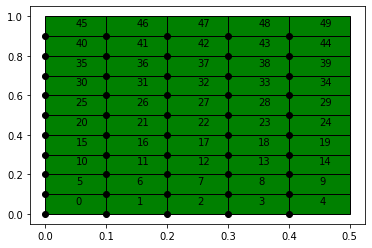

In [17]:
fig = plt.figure()
n_cells = 100
u.draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')
for x in np.arange(xmin, xmax, dx):
    for y in np.arange(ymin, ymax, dy):
        c = u.fromXYToCell(x, y, (xmin, xmax, dx), (ymin, ymax, dy))
        x, y = u.fromCellToXY(c, (xmin, xmax, dx), (ymin, ymax, dy))
        plt.plot(x, y, marker='.', markersize=12, color='black')
        plt.gca().text(x+dx/2, y+dy/2, str(c))

In [20]:
def coverageFromXY(x, y, width, length, x_lim, y_lim):
    """coverageFromXY(x, y, width, length, x_lim, y_lim)
        input:
          x, y: coordinate of the lower left corner of the coverage area
          width, length: width and length of the coverage area
          x_lim: (xmin, xmax, dx)
          y_lim: (ymin, ymax, dy) 
        returns:
          cells that are covered when the robot is deployed at x, y
    """    
    xmin, xmax, dx = x_lim
    ymin, ymax, dy = y_lim    
    
    assert x >= xmin and x <= xmax
    assert y >= ymin and y <= ymax
    
    cells = []
    cells.append(u.fromXYToCell(x, y, x_lim, y_lim))
    cells.append(u.fromXYToCell(min(x+width, xmax-dx), y, x_lim, y_lim))
    cells.append(u.fromXYToCell(x, min(y+length, ymax-dy), x_lim, y_lim))    
    cells.append(u.fromXYToCell(min(x+width, xmax-dx), min(y+length, ymax-dx), x_lim, y_lim))
    
    return set(cells)

In [21]:
cells = coverageFromXY(x=0.3, y=0.0, width=2*dx, length=2*dy, x_lim=(xmin, xmax, dx), y_lim=(ymin, ymax, dy) )
print(cells)

{3, 4, 13, 14}


In [22]:
def coverageFromCell(c, width, length, rows, columns):
    """coverageFromCell(c, width, length, x_lim, y_lim)
        input:
          c: cell number (bottom left point of the coverage area)
          width, length: width and length of the coverage area in number of cells
          rows, columns: number of rows and columns of the matrix representing the coverage area.
        returns:
          cells that are covered when the robot is deployed at x, y
    """  
    
    n_cells = rows*columns
    assert c <= n_cells, f"cell number {c} must be less than {rows*columns}"
    
    coverage_cells = [c]
    xcells = list(range(c%columns, min(c%columns+width, columns)))
    ycells = list(range(c%columns+columns, length*columns, columns))
    
    for xc in xcells:
        ycells += list(range(xc+columns, length*columns, columns))
        
    xcells = list(c-c%columns+np.array(xcells))
    ycells = list(c-c%columns+np.array(ycells))

    coverage_cells+=xcells
    coverage_cells+=ycells
    
    coverage_cells = [c for c in coverage_cells if c < n_cells]
    return list(np.unique(coverage_cells))

coverage: [45, 46, 47]


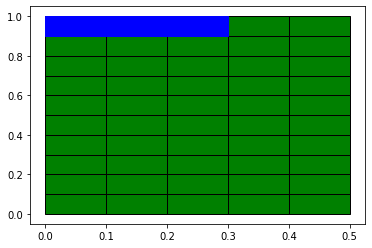

In [26]:
columns = round((xmax-xmin)/dx)
rows    = round((ymax-ymin)/dy)
coverage_cells = coverageFromCell(45, width=3, length=2, rows=rows, columns=columns)

print(f'coverage: {coverage_cells}')

fig = plt.figure()
n_cells = 100
u.draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')
for c in coverage_cells:
        x, y = u.fromCellToXY(c, (xmin, xmax, dx), (ymin, ymax, dy))
        u.draw_cell(x, y, dx, dy, edgecolor='blue', facecolor='blue')             

In [280]:
def visibilityMatrix(area, sensor):    
    rows, columns = area
    width, length = sensor
    V = np.zeros((rows*columns, rows*columns))
    for c in range(rows*columns):
        coverage_cells = coverageFromCell(c, width, length, rows=rows, columns=columns)
        V[c, coverage_cells] = 1 
        
    return V


get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

In [283]:
xmin, xmax, dx = 0, 0.5, .1
ymin, ymax, dy = 0, 1, .1

columns = round((xmax-xmin)/dx)
rows    = round((ymax-ymin)/dy)
area    = (rows, columns)
sensor  = (2, 2) # width (x), length (y)

V = visibilityMatrix(area, sensor)


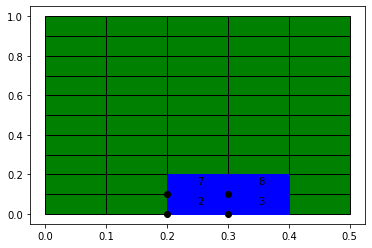

In [284]:
# This code checks the visibility matrix and represents the coverage obtained 
# if the robot is place in one specific cell.

cell_number = 2


fig = plt.figure()
u.draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')

visibility = np.where(V[cell_number,:] == 1)[0]

for c in visibility:
    x, y = u.fromCellToXY(c, (xmin, xmax, dx), (ymin, ymax, dy))
    u.draw_cell(x, y, dx, dy, edgecolor='blue', facecolor='blue') 
    plt.plot(x, y, marker='.', markersize=12, color='black')
    plt.gca().text(x+dx/2, y+dy/2, str(c))

## Solving the problem 

In [309]:
xmin, xmax, dx = 0, 0.5, .1
ymin, ymax, dy = 0, 1, .1

area_size = (xmax-xmin)*(ymax-ymin)
n_cells = round(area_size/(dx*dy))

columns = round((xmax-xmin)/dx)
rows    = round((ymax-ymin)/dy)
area    = (rows, columns)
sensor  = (2, 10) # width (x), length (y)
n_robots = 2


V = visibilityMatrix(area, sensor)

print(f'Area     : {area_size}')
print(f'n.cells  : {n_cells}')
print(f'n.robots : {n_robots}')

B = cvx.Variable((n_robots, n_cells), name='B', boolean=True)

Area     : 0.5
n.cells  : 50
n.robots : 2


In [310]:
# a few tests
# p_rxc_matrix = cvx.Parameter((n_robots, n_cells), name='p_rxc_matrix', boolean=True)
# p_rxc_matrix.value = np.ones((n_robots, n_cells))

# print(p_rxc_matrix.value)

# print(rxc_matrix[1,:])
# print(rxc_matrix.shape)
# print(sum(p_rxc_matrix[0,:]).value)
# round(mapr[0]*n_cells), round(mapr[1]*n_cells)

### Define the constraints

In [311]:
constraints = []

for i in range(B.shape[0]): # each robot can only be in one cell    
    constraints.append(sum(B[i,:]) <= 1)
    
for i in range(B.shape[1]): # each cell has to be covered only once.
    #constraints.append(sum(B[:,i]) <= 1)
    constraints.append(sum((B*V)[:,i]) <= 1)

In [312]:
# constraints

### Define the objective function

In [313]:
# Our total utility is the area that we cover
total_utility = cvx.sum(B*V)

In [314]:
total_utility

Expression(AFFINE, NONNEGATIVE, ())

### Run the solver

In [315]:
# We tell cvxpy that we want to maximize total utility 
# subject to weight_constraint. All constraints in 
# cvxpy must be passed as a list
area_problem = cvx.Problem(cvx.Maximize(total_utility), constraints)

In [316]:
# Solving the problem
area_problem.solve(solver=cvx.GLPK_MI, qcp=True)
#area_problem.solve(solver=cvx.ECOS)
print("optimal objective value: {}".format(area_problem.value))

optimal objective value: 40.0


In [317]:
print('Solution: ')
print(B.value)
print(B.value.dot(V))

Solution: 
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
[[1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0.
  0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0.
  0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
  0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1.
  1. 0.]]


In [318]:
np.sum(np.amax(B.value.dot(V), axis=0))

40.0

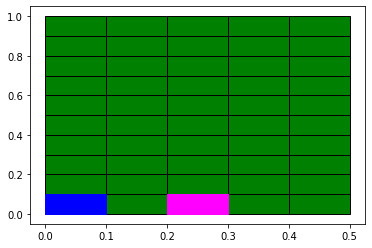

In [319]:
r_colors = ['blue', 'magenta', 'cyan']
u.draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')
u.draw_allocation(B.value, xmin, xmax, dx, ymin, ymax, dy, n_cells=n_cells, n_robots=n_robots, r_colors=r_colors)

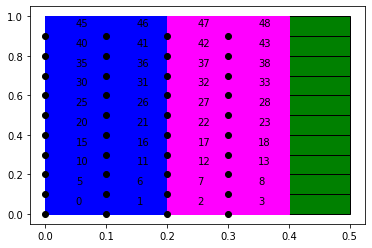

In [320]:
fig = plt.figure()
u.draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')


for idx, cell_number in enumerate(np.where(B.value == 1)[1]):
    visibility = np.where(V[cell_number,:] == 1)[0]

    for c in visibility:
        x, y = u.fromCellToXY(c, (xmin, xmax, dx), (ymin, ymax, dy))
        u.draw_cell(x, y, dx, dy, edgecolor=r_colors[idx], facecolor=r_colors[idx]) 
        plt.plot(x, y, marker='.', markersize=12, color='black')
        plt.gca().text(x+dx/2, y+dy/2, str(c))

# Greedy algorithm

In [342]:
n_robots = 3
robot_area_coverage = [[4, 4, 0],  # width, length, rotation
                       [5, 3, 0],
                       [1, 2, 0]]


xmin, xmax, dx = 0, 1., 0.2
ymin, ymax, dy = 0, 1., 0.2

Area = (xmax-xmin)*(ymax-ymin)
n_cells = round(Area/(dx*dy))
n_cells_x = round((xmax-xmin)/dx)
n_cells_y = round((ymax-ymin)/dy)

## Finds the (sub)optimal allocation

In [343]:
def find_solution(n_robots, n_cells, robot_area_coverage):
    coverage = []
    cells = []
    rxc_matrix = np.zeros(n_cells)
    max_robot_area_coverage_value = 0

    for r in range(n_robots):
        min_intersection = list(range(n_cells)) # max number
        width=robot_area_coverage[r][0]
        length=robot_area_coverage[r][1]
        max_area_this_robot = width*length
        current_area_this_robot = 0

        for c in range(n_cells):
            coverage_cells = coverageFromCell(c, width=width, length=length, rows=n_cells_y, columns=n_cells_x)        
            print(f'robot {r}, area:{coverage_cells}')
            intersection = list(set(coverage_cells).intersection(coverage))

            # this is the amount of area that this robot is covering now.
            area_this_robot = len(coverage_cells)

            if area_this_robot >= current_area_this_robot:
                this_robot_in_cell = c
                current_area_this_robot = area_this_robot

            if len(intersection) == 0 and area_this_robot == max_area_this_robot:
                # this is a good solution for robot r
                print('Nothing more to gain: empty intersection found and max area met.')
                break

        coverage += coverage_cells


        # and saves the solution
        cells.append(this_robot_in_cell)
        rxc_matrix[c] = 1 
    return cells
    
#   coverage_value=sum(coverage)

In [344]:
cells = find_solution(n_robots, n_cells, robot_area_coverage)

robot 0, area:[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18]
Nothing more to gain: empty intersection found and max area met.
robot 1, area:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
robot 1, area:[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14]
robot 1, area:[2, 3, 4, 7, 8, 9, 12, 13, 14]
robot 1, area:[3, 4, 8, 9, 13, 14]
robot 1, area:[4, 9, 14]
robot 1, area:[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
robot 1, area:[6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
robot 1, area:[7, 8, 9, 12, 13, 14, 17, 18, 19]
robot 1, area:[8, 9, 13, 14, 18, 19]
robot 1, area:[9, 14, 19]
robot 1, area:[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
robot 1, area:[11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24]
robot 1, area:[12, 13, 14, 17, 18, 19, 22, 23, 24]
robot 1, area:[13, 14, 18, 19, 23, 24]
robot 1, area:[14, 19, 24]
robot 1, area:[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
robot 1, area:[16, 17, 18, 19, 21, 22, 23, 24]
robot 1, area:[17, 18, 19, 22, 23, 24]
rob

In [345]:
rxc_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [346]:
#cells, coverage

In [347]:
#sum(np.ones(len(coverage)))

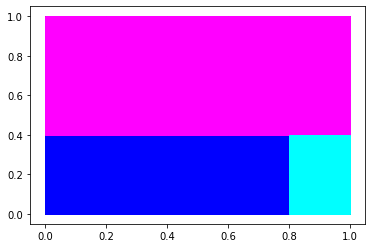

In [348]:
fig = plt.figure()
u.draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')


r_colors = ['blue', 'magenta', 'cyan']

for r in range(n_robots):
    width =robot_area_coverage[r][0]
    length=robot_area_coverage[r][1]
    coverage_cells = coverageFromCell(cells[r], width=width, length=length, rows=n_cells_x, columns=n_cells_y)
    for c in coverage_cells:
        x, y = u.fromCellToXY(c, (xmin, xmax, dx), (ymin, ymax, dy))
        u.draw_cell(x, y, dx, dy, edgecolor=r_colors[r], facecolor=r_colors[r])        



# References 

1. [Total variation in-painting](https://www.cvxpy.org/examples/applications/tv_inpainting.html)
2. [Cell tower coverage](http://examples.gurobi.com/cell-tower-coverage/)
3. [Max coverage](https://github.com/njtierney/maxcovr)
4. [cvxpy coverage](https://stackoverflow.com/questions/53333253/how-to-solve-a-facility-location-allocation-ip-problem-in-cvxpy)
5. [Find optimal location for x,y coordinates](https://stackoverflow.com/questions/47147813/finding-the-optimized-location-for-a-list-of-coordinates-x-and-y)
6. [What is CVXPY](https://www.cvxpy.org/tutorial/intro/index.html#parameters)
7. [Solving the knapsack problem](https://medium.com/@fabianterh/how-to-solve-the-knapsack-problem-with-dynamic-programming-eb88c706d3cf)